Packages, Libraries and Framework

In [1]:
# Downloading Packages Cause Keras-rl2 is legacy :(
!pip install keras-rl2==1.0.5
!pip install gymnasium==0.29.1
!pip install tensorflow==2.12.0

print("Packages Installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.1
    Uninstalling gymnasium-1.1.1:
      Successfully uninstalled gymnasium-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to 

Packages Installed


In [1]:
# Importing Libraries
import os
import random
from IPython.display import Image, display
import pickle
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Lambda
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import Callback, TensorBoard
from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

Creating the Environment

In [2]:
# Creating the Environment Taxi
class TaxiEnvWrapper(gym.Wrapper):
    """Handles Gymnasium's tuple returns for compatibility"""
    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        return obs

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        done = terminated or truncated

        return obs, reward, done, info

# Create wrapped environment
env = TaxiEnvWrapper(gym.make("Taxi-v3", render_mode="rgb_array"))

# Test random agent
num_episodes = 5
max_steps = 10

for episode in range(num_episodes):
    obs = env.reset()
    total_reward = 0
    done = False
    step_count = 0

    print(f"Episode {episode+1}")

    while not done and step_count < max_steps:
        # Sample random action
        action = env.action_space.sample()

        # Take step in environment
        next_obs, reward, done, info = env.step(action)

        # Update total reward and observation
        total_reward += reward
        obs = next_obs
        step_count += 1

        print(f"Step {step_count}, Action: {action}, Reward: {reward}")

    print(f"Episode {episode+1} finished with total reward: {total_reward} in {step_count} steps\n")

env.close()

Episode 1
Step 1, Action: 1, Reward: -1
Step 2, Action: 5, Reward: -10
Step 3, Action: 2, Reward: -1
Step 4, Action: 1, Reward: -1
Step 5, Action: 3, Reward: -1
Step 6, Action: 0, Reward: -1
Step 7, Action: 5, Reward: -10
Step 8, Action: 4, Reward: -10
Step 9, Action: 2, Reward: -1
Step 10, Action: 0, Reward: -1
Episode 1 finished with total reward: -37 in 10 steps

Episode 2
Step 1, Action: 5, Reward: -10
Step 2, Action: 0, Reward: -1
Step 3, Action: 4, Reward: -10
Step 4, Action: 0, Reward: -1
Step 5, Action: 3, Reward: -1
Step 6, Action: 0, Reward: -1
Step 7, Action: 1, Reward: -1
Step 8, Action: 4, Reward: -10
Step 9, Action: 1, Reward: -1
Step 10, Action: 3, Reward: -1
Episode 2 finished with total reward: -37 in 10 steps

Episode 3
Step 1, Action: 5, Reward: -10
Step 2, Action: 3, Reward: -1
Step 3, Action: 4, Reward: -10
Step 4, Action: 1, Reward: -1
Step 5, Action: 3, Reward: -1
Step 6, Action: 5, Reward: -10
Step 7, Action: 3, Reward: -1
Step 8, Action: 4, Reward: -10
Step 9, 

Creating an Agent

In [3]:
# Build the Dueling DQN model
def build_dueling_model(states, actions):
    input_layer = Input(shape=(1, states))
    flat = Flatten()(input_layer)
    dense = Dense(256, activation='relu')(flat)
    dense = Dense(256, activation='relu')(dense)

    # Value stream
    value = Dense(256, activation='relu')(dense)
    value = Dense(1, activation='linear')(value)

    # Advantage stream
    advantage = Dense(256, activation='relu')(dense)
    advantage = Dense(actions, activation='linear')(advantage)

    # Combine value and advantage into Q-values
    q_values = Lambda(
        lambda x: x[0] + (x[1] - K.mean(x[1], axis=1, keepdims=True))
    )([value, advantage])

    model = Model(inputs=input_layer, outputs=q_values)
    return model

# Verify with Taxi-v3's observation space
model = build_dueling_model(env.observation_space.n, env.action_space.n)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 500)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 500)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          128256      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                              

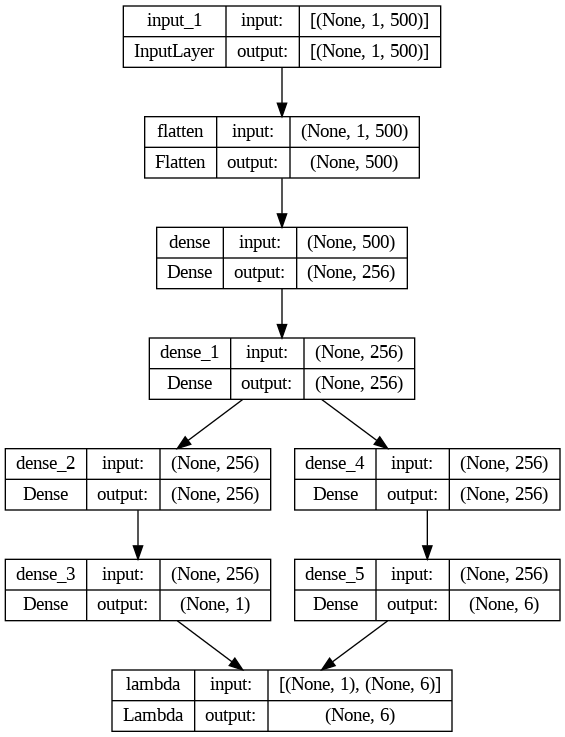

In [4]:
# Visualizing the Model Architecture'
plot_model(model, to_file="/content/drive/MyDrive/CabMind/CabMind_model.png", show_shapes=True, show_layer_names=True)
display(Image(filename="/content/drive/MyDrive/CabMind/CabMind_model.png"))

In [5]:
# Processor class
class OneHotProcessor(Processor):
    def __init__(self, env):
        super().__init__()
        self.state_size = env.observation_space.n

    def process_observation(self, observation):
        # Handle potential tuple observation from Gymnasium reset
        if isinstance(observation, tuple):
            observation = observation[0]
        one_hot = np.zeros(self.state_size, dtype=np.float32)
        one_hot[int(observation)] = 1.0
        return one_hot

    def process_step(self, observation, reward, done, info):
        observation = self.process_observation(observation)
        reward = float(reward)
        # Filter out non-scalar info for Keras-RL compatibility if necessary
        processed_info = {k: v for k, v in info.items() if np.isscalar(v)}
        return observation, reward, done, processed_info

# Specifying the behavior of the Agent (with modifications)
def build_agent(model, actions, env, total_training_steps):

    # Configure Epsilon Annealing Policy
    policy = LinearAnnealedPolicy(
        inner_policy=EpsGreedyQPolicy(),
        attr='eps',
        value_max=1.0,
        value_min=0.001,
        value_test=0.1,
        nb_steps=int(total_training_steps * 0.7)
    )

    # Configure Memory
    memory = SequentialMemory(
        limit=100000,
        window_length=1,
        ignore_episode_boundaries=False
    )

    # Initialize the processor
    processor = OneHotProcessor(env)

    # Build the DQNAgent
    dqn = DQNAgent(
        model=model,
        memory=memory,
        policy=policy,
        processor=processor,
        nb_actions=actions,
        nb_steps_warmup=1000,
        target_model_update=8e-2,
        enable_double_dqn=True,
        batch_size=16,
        gamma=0.97,
        train_interval=1
    )

    return dqn

In [6]:
TOTAL_TRAINING_STEPS = 180000

# Building and Compiling
dqn = build_agent(model, env.action_space.n, env, TOTAL_TRAINING_STEPS)
dqn.compile(Adam(learning_rate=5e-4), metrics=["mae"])

Training the Agent

In [7]:
# Track action counts
action_counts = np.zeros(env.action_space.n, dtype=int)
cumulative_action_counts = np.zeros(env.action_space.n, dtype=int)

class ActionTracker(Callback):
    def on_step_end(self, step, logs={}):
        action = logs.get("action")
        if action is not None:
            action_counts[action] += 1
            cumulative_action_counts[action] += 1

# Create callback instances
action_tracker = ActionTracker()

In [8]:
# Train model with callbacks
history = dqn.fit(env, nb_steps=TOTAL_TRAINING_STEPS, visualize=False, verbose=1,
                 callbacks=[action_tracker])

# Print Training Summary
metric = history.history['episode_reward']
print(f"Total Episodes: {len(metric)}")
print(f"Average Reward: {sum(metric) / len(metric):.2f} | Max: {max(metric)} | Min: {min(metric)}")

Training for 180000 steps ...
Interval 1 (0 steps performed)
   86/10000 [..............................] - ETA: 11s - reward: -4.0349

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 165s 16ms/step - reward: -3.7705
50 episodes - episode_reward: -750.960 [-893.000, -605.000] - loss: 0.664 - mae: 13.096 - mean_q: -12.089 - mean_eps: 0.956 - prob: 1.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 171s 17ms/step - reward: -3.4099
59 episodes - episode_reward: -576.729 [-839.000, 9.000] - loss: 1.256 - mae: 10.548 - mean_q: -4.623 - mean_eps: 0.881 - prob: 1.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 173s 17ms/step - reward: -3.0733
87 episodes - episode_reward: -351.529 [-767.000, -54.000] - loss: 0.761 - mae: 6.155 - mean_q: 4.389 - mean_eps: 0.802 - prob: 1.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 174s 17ms/step - reward: -2.6521
172 episodes - episode_reward: -156.337 [-418.000, 9.000] - loss: 0.288 - mae: 5.172 - mean_q: 7.201 - mean_eps: 0.723 - prob: 1.000

Interval 5 (40000 steps performe

Visualizing the Training Results

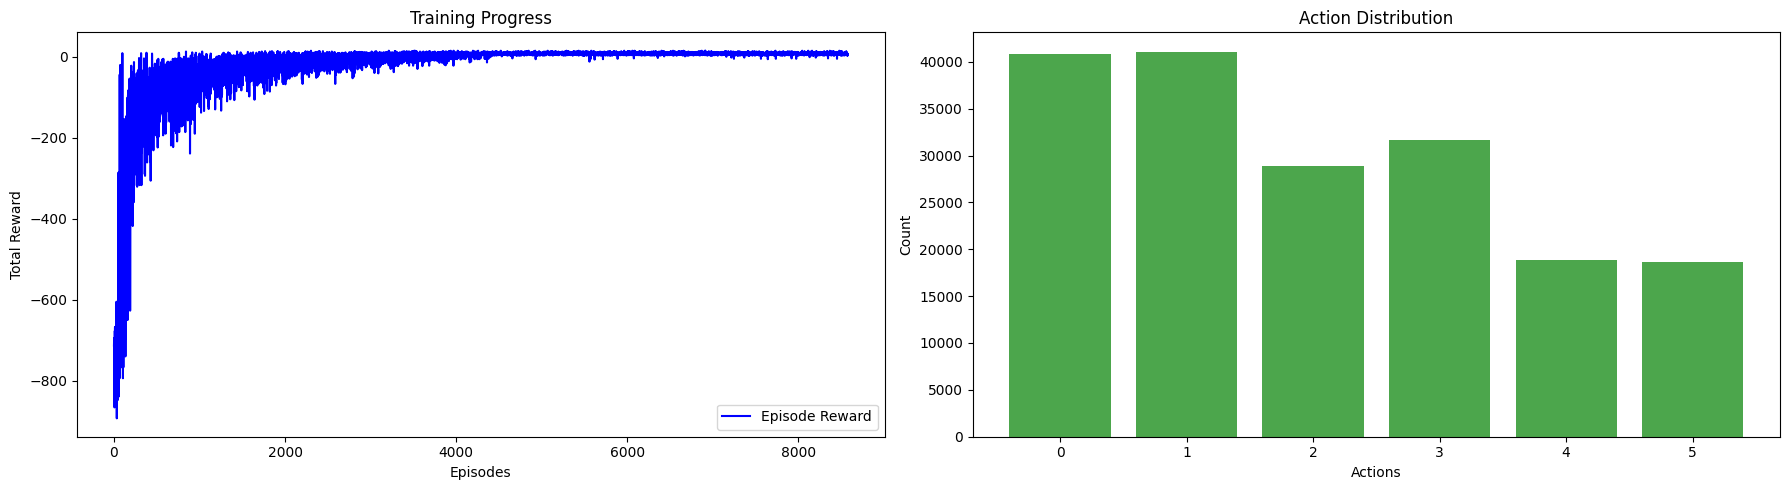

In [9]:
# Plot Training Progress and Action Distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot Episode Reward
axes[0].plot(history.history['episode_reward'], label="Episode Reward", color='blue')
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("Total Reward")
axes[0].set_title("Training Progress")
axes[0].legend()

# Plot Action Distribution
actions = np.arange(len(cumulative_action_counts))
axes[1].bar(actions, cumulative_action_counts, color='green', alpha=0.7)
axes[1].set_xlabel("Actions")
axes[1].set_ylabel("Count")
axes[1].set_title("Action Distribution")

# Show Plot
plt.tight_layout()
plt.show()

Testing the Trained Agent

In [11]:
# Test the trained agent and collect performance data
num_test_episodes = 3000

# Use the test method instead of fit
history = dqn.test(env, nb_episodes=num_test_episodes, visualize=False, verbose=1)

# Extract performance metrics
episode_rewards = history.history['episode_reward']
episode_steps = history.history.get('nb_steps_per_episode', [])

# Print summary statistics
print(f"Average Reward: {np.mean(episode_rewards):.2f}")
print(f"Max Reward: {np.max(episode_rewards)} | Min: {np.min(episode_rewards)}")

if episode_steps:
    print(f"Average Steps: {np.mean(episode_steps):.2f}")

# Count successful episodes (reward > 0 for Taxi-v3)
successful_episodes = sum(1 for reward in episode_rewards if reward > 0)
print(f"Successful Episodes: {successful_episodes} / {num_test_episodes}")

# Close the environment
env.close()

Testing for 3000 episodes ...
Episode 1: reward: 4.000, steps: 17
Episode 2: reward: 11.000, steps: 10
Episode 3: reward: 8.000, steps: 13
Episode 4: reward: 7.000, steps: 14
Episode 5: reward: 10.000, steps: 11
Episode 6: reward: 5.000, steps: 16
Episode 7: reward: 8.000, steps: 13
Episode 8: reward: 5.000, steps: 16
Episode 9: reward: 3.000, steps: 18
Episode 10: reward: 8.000, steps: 13
Episode 11: reward: 9.000, steps: 12
Episode 12: reward: 3.000, steps: 18
Episode 13: reward: 7.000, steps: 14
Episode 14: reward: 7.000, steps: 14
Episode 15: reward: 8.000, steps: 13
Episode 16: reward: 5.000, steps: 16
Episode 17: reward: 9.000, steps: 12
Episode 18: reward: 7.000, steps: 14
Episode 19: reward: 11.000, steps: 10
Episode 20: reward: 12.000, steps: 9
Episode 21: reward: 6.000, steps: 15
Episode 22: reward: 7.000, steps: 14
Episode 23: reward: 4.000, steps: 17
Episode 24: reward: 7.000, steps: 14
Episode 25: reward: 8.000, steps: 13
Episode 26: reward: 8.000, steps: 13
Episode 27: re

Visualizing the Testing Results

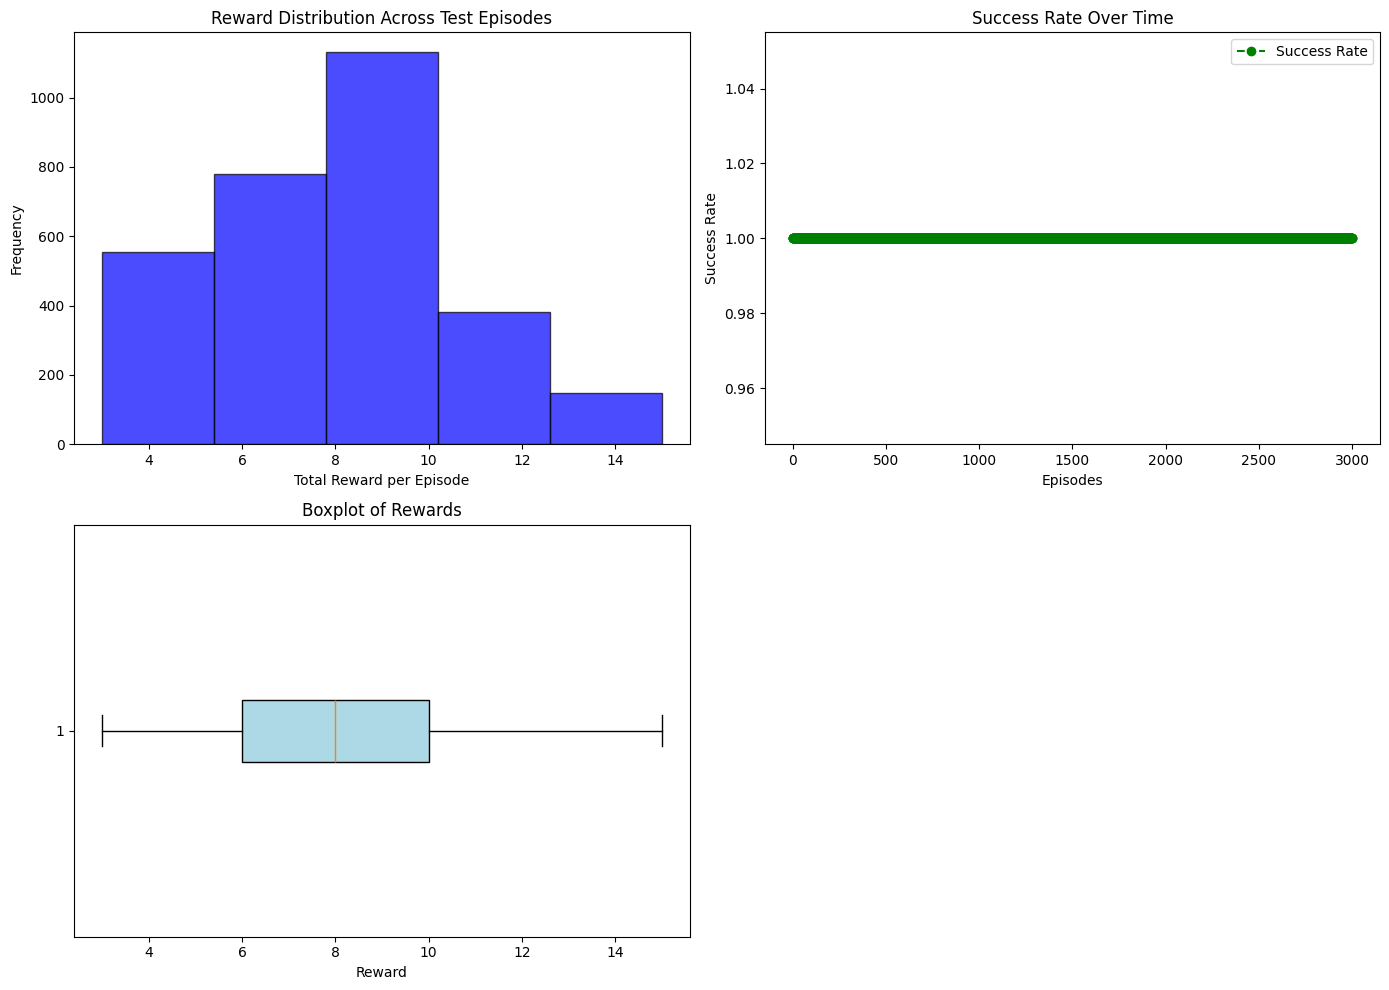

In [12]:
# Create a figure with subplots for test insights
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reward Distribution Histogram
axes[0, 0].hist(episode_rewards, bins=min(5, len(episode_rewards)), color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel("Total Reward per Episode")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Reward Distribution Across Test Episodes")

# Success Rate Curve
success_rates = [sum(1 for reward in episode_rewards[:i+1] if reward > 0) / (i+1) for i in range(len(episode_rewards))]
axes[0, 1].plot(success_rates, marker='o', color='green', linestyle='dashed', label="Success Rate")
axes[0, 1].set_xlabel("Episodes")
axes[0, 1].set_ylabel("Success Rate")
axes[0, 1].set_title("Success Rate Over Time")
axes[0, 1].legend()

# Boxplot of Episode Rewards
axes[1, 0].boxplot(episode_rewards, vert=False, patch_artist=True,
                  boxprops=dict(facecolor='lightblue'))
axes[1, 0].set_title("Boxplot of Rewards")
axes[1, 0].set_xlabel("Reward")

# Hide the unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

Saving the Agent

In [13]:
# Define a directory to save the model
save_dir = "/content/drive/MyDrive/CabMind/"
os.makedirs(save_dir, exist_ok=True)

# Save the model weights
model_weights_path = os.path.join(save_dir, "CabMind_weights.h5")
dqn.save_weights(model_weights_path, overwrite=True)
print(f"Model weights saved to {model_weights_path}")

# Save the model architecture
model_architecture_path = os.path.join(save_dir, "CabMind_architecture.json")
with open(model_architecture_path, "w") as f:
    f.write(dqn.model.to_json())
print(f"Model architecture saved to {model_architecture_path}")

# Save the agent's memory
memory_path = os.path.join(save_dir, "CabMind_memory.pkl")
with open(memory_path, "wb") as f:
    pickle.dump(dqn.memory, f)
print(f"Agent memory saved to {memory_path}")

Model weights saved to /content/drive/MyDrive/CabMind/CabMind_weights.h5
Model architecture saved to /content/drive/MyDrive/CabMind/CabMind_architecture.json
Agent memory saved to /content/drive/MyDrive/CabMind/CabMind_memory.pkl
